In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/28_0_0_20170117180555824.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/17_1_4_20170103222931966.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/44_0_3_20170119201022260.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/35_0_2_20170116182734834.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/76_0_0_20170104213515132.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/36_1_0_20170116165722892.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/34_0_3_20170119200815948.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/18_1_0_20170104022856102.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/40_1_1_20170113011948248.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/45_0_0_20170117180013541.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/26_1_1_20170117153641469.jpg.c

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [4]:
data_dir = '/kaggle/input/utkface-new/UTKFace'

In [5]:
images = glob.glob(os.path.join(data_dir, '*.jpg'))
print(f"Total images found: {len(images)}")

Total images found: 23708


In [6]:
random.shuffle(images)

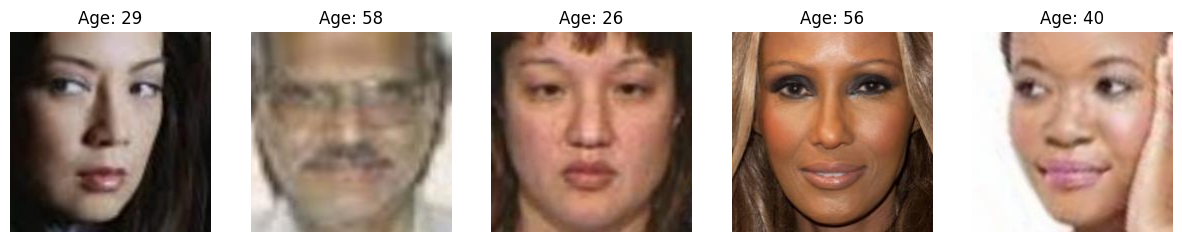

In [7]:
sample_files = random.sample(images, 5)
plt.figure(figsize=(15,5))
for idx, f in enumerate(sample_files):
    img = Image.open(f)
    age = int(os.path.basename(f).split('_')[0])
    plt.subplot(1,5,idx+1)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')
plt.show()

In [8]:
class AgeDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        age = int(os.path.basename(img_path).split('_')[0])

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(age, dtype=torch.float32)

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [10]:
#splitting data
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)

In [11]:
train_dataset = AgeDataset(X_train, transform=train_transform)
test_dataset = AgeDataset(X_test, transform=test_transform)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)} | Test samples: {len(test_dataset)}")

Train samples: 18966 | Test samples: 4742


In [13]:
#loading pretrained model
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s] 


In [14]:
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(2048, 1)
)


In [15]:
model = model.to(device)

In [16]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [17]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)


In [18]:
train_loss = []
val_loss = []
best_val_loss = float('inf')  

epochs = 40

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_loss.append(epoch_train_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    mae_running = 0.0  

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            mae_running += torch.sum(torch.abs(outputs - labels)).item()

    epoch_val_loss = val_running_loss / len(test_loader.dataset)
    epoch_mae = mae_running / len(test_loader.dataset)
    val_loss.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {epoch_train_loss:.2f} | Val Loss: {epoch_val_loss:.2f} | Val MAE: {epoch_mae:.2f}")

    # Step scheduler
    scheduler.step(epoch_val_loss)

    #  Save best model so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Saved new best model at epoch {epoch+1} with Val Loss: {best_val_loss:.2f}")


Epoch [1/40] Train Loss: 28.07 | Val Loss: 21.68 | Val MAE: 21.68
Saved new best model at epoch 1 with Val Loss: 21.68
Epoch [2/40] Train Loss: 14.11 | Val Loss: 10.76 | Val MAE: 10.76
Saved new best model at epoch 2 with Val Loss: 10.76
Epoch [3/40] Train Loss: 8.91 | Val Loss: 7.87 | Val MAE: 7.87
Saved new best model at epoch 3 with Val Loss: 7.87
Epoch [4/40] Train Loss: 7.64 | Val Loss: 7.06 | Val MAE: 7.06
Saved new best model at epoch 4 with Val Loss: 7.06
Epoch [5/40] Train Loss: 7.06 | Val Loss: 6.71 | Val MAE: 6.71
Saved new best model at epoch 5 with Val Loss: 6.71
Epoch [6/40] Train Loss: 6.73 | Val Loss: 6.46 | Val MAE: 6.46
Saved new best model at epoch 6 with Val Loss: 6.46
Epoch [7/40] Train Loss: 6.50 | Val Loss: 6.38 | Val MAE: 6.38
Saved new best model at epoch 7 with Val Loss: 6.38
Epoch [8/40] Train Loss: 6.39 | Val Loss: 6.29 | Val MAE: 6.29
Saved new best model at epoch 8 with Val Loss: 6.29
Epoch [9/40] Train Loss: 6.27 | Val Loss: 6.18 | Val MAE: 6.18
Saved new

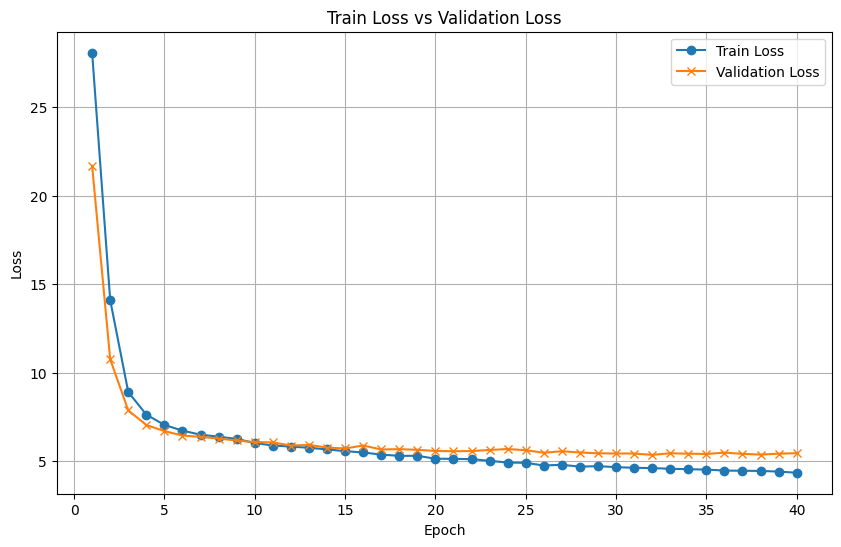

In [19]:

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Predicted age: 11.87


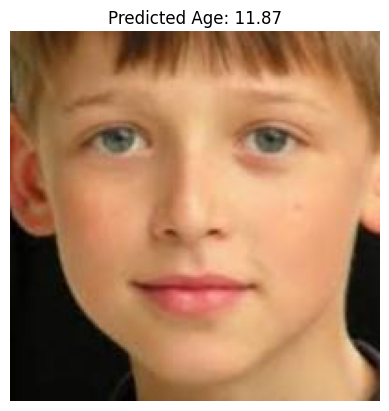

In [36]:
from PIL import Image
from torchvision import transforms

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img = Image.open('/kaggle/input/utkface-new/crop_part1/10_0_0_20161220222308131.jpg.chip.jpg').convert("RGB")
input_tensor = transform(img).unsqueeze(0)  

with torch.no_grad():
    output = model(input_tensor.to(device)).squeeze().item() 

print(f"Predicted age: {output:.2f}")
plt.imshow(img)
plt.title(f"Predicted Age: {output:.2f}")
plt.axis('off')
plt.show()